<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/Covid/covid_open_data_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-open-data paper


This colab shows how to use the [Covid19-open-data](https://github.com/GoogleCloudPlatform/covid-19-open-data) repository. We use the [v3 schema](https://docs.google.com/document/d/119NjmUMYs2a2rdO_cL5gnCK331BxG7nXzuGj5mUam_c/edit?resourcekey=0-c9vlXgdUekrqfc1HOxCAMQ#).
We focus on the static 2020 snapshot of the dataset.

[See here](#death-rates-per-country-time-series) for details.


In [1]:
from typing import Callable, List, Tuple
import pandas as pd
import seaborn
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
from IPython.display import display, HTML
import math

from typing import List
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn
seaborn.set()
seaborn.set_style("whitegrid")

plt.rcParams.update({'font.size': 48, 'legend.fontsize': 18})
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

# Overview of individual tables

In [2]:
# individual data tables (latest date)
ROOT = 'https://storage.googleapis.com/covid19-open-data/v3'
# set default_na=False to prevent reading of records with key "NA" (Namibia) as NaN
READ_OPTS = dict(na_values=[''], keep_default_na=False, sep=',', engine='c')
def read_table_latest(name, nrows=0):
  URL = f'{ROOT}/latest/{name}.csv'
  print('reading ', URL)
  df = pd.read_csv(URL, nrows=3, **READ_OPTS)
  return df

In [3]:

table_names = ['index', 'epidemiology', 'hospitalizations', 'by-age', 'by-sex',
            'lawatlas-emergency-declarations', 'oxford-government-response', 
            'weather', 'mobility',   'google-search-trends',
           'demographics', 'economy',   'geography', 'health', 'worldbank']

table_cols = {}
table_ncols = {}
table_static = {}
for i, table in enumerate(table_names):
  URL = f'{ROOT}/{table}.csv'
  print('reading ', URL)
  df = pd.read_csv(URL, nrows=0, **READ_OPTS) # header only
  cols = list(df.columns)
  cols.remove('location_key') # every table has a location_key
  if 'date' in cols:
    cols.remove('date')
    is_static = False
  else:
    is_static = True
  table_static[table] = is_static
  ncols = len(cols)
  table_cols[table] = cols
  table_ncols[table] = ncols

print(table_ncols)
print(table_static)
print(table_cols)

reading  https://storage.googleapis.com/covid19-open-data/v3/index.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/epidemiology.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/hospitalizations.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/by-age.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/by-sex.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/lawatlas-emergency-declarations.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/oxford-government-response.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/weather.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/mobility.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/google-search-trends.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/demographics.csv
reading  https://storage.googleapis.com/covid19-open-data/v3/economy.csv
reading  https://storage.googleapis.com/covid19-open

In [4]:
for table, cols in table_cols.items():
  print(table)
  print(cols)

index
['wikidata_id', 'datacommons_id', 'country_code', 'country_name', 'subregion1_code', 'subregion1_name', 'subregion2_code', 'subregion2_name', 'locality_code', 'locality_name', 'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3', 'aggregation_level']
epidemiology
['new_confirmed', 'new_deceased', 'new_recovered', 'new_tested', 'cumulative_confirmed', 'cumulative_deceased', 'cumulative_recovered', 'cumulative_tested']
hospitalizations
['new_hospitalized', 'cumulative_hospitalized', 'current_hospitalized', 'new_intensive_care', 'cumulative_intensive_care', 'current_intensive_care', 'new_ventilator', 'cumulative_ventilator', 'current_ventilator']
by-age
['new_confirmed_age_0', 'new_confirmed_age_1', 'new_confirmed_age_2', 'new_confirmed_age_3', 'new_confirmed_age_4', 'new_confirmed_age_5', 'new_confirmed_age_6', 'new_confirmed_age_7', 'new_confirmed_age_8', 'new_confirmed_age_9', 'cumulative_confirmed_age_0', 'cumulative_confirmed_age_1', 'cumulative_confirmed_age_2', 'cumulative_confirmed_ag

In [5]:
table_sources = {}
for t in table_names:
  table_sources[t] = ['Various']
table_sources['index'] = ['Wikidata', 'Eurostat']
table_sources['economy'] = ['Wikidata', 'Eurostat']
table_sources['lawatlas-emergency-declarations'] = ['Lawatlas Project']
table_sources['geography'] = ['Wikidata']
table_sources['health'] = ['Wikidata', 'Wordlbank', 'Eurostat']
table_sources['mobility'] = ['Google']
table_sources['google-search-trends'] = ['Google']
table_sources['oxford-government-response'] = ['U. Oxford']
table_sources['weather'] = ['NOAA']
table_sources['worldbank'] = ['Worldbank']


A = set(table_names)
B = set(table_sources.keys())
print(B-A)

set()


In [6]:

table_names = ['index', 'epidemiology', 'hospitalizations', 'by-age', 'by-sex',
            'lawatlas-emergency-declarations', 'oxford-government-response', 
            'weather', 'mobility',   'google-search-trends',
           'demographics', 'economy',   'geography', 'health', 'worldbank']

In [7]:
table_text = {}
table_text['index'] = 'Name of each location'
table_text['demographics'] = 'Current population statistics'
table_text['economy'] = 'Current economic indicators'
table_text['epidemiloogy'] = 'New and cumulative cases, deaths, tests, recoveries'
table_text['lawatlas-emergency-declarations'] = 'Government mandates'
table_text['geography'] = 'Spatial information'
table_text['health'] = 'Current health indicators'
table_text['hospitalizations'] = 'New and cumulative data for COVID patients'
table_text['mobility'] = 'Relative amount of movement to location types'
table_text['google-search-trends'] = 'Relative trends in COVID-related search terms'
table_text['oxford-government-response'] = 'Government mandates'
table_text['weather'] = 'Metereological information'
table_text['worldbank'] = 'Latest economic indicators'
table_text['by-age'] = 'Epidemiological and hospitalization data stratified by age'
table_text['by-sex'] = 'Epidemiological and hospitalization data stratified by sex'


In [8]:


pd.options.display.width = 1200
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

df = pd.DataFrame({'Table': table_names, '#columns': table_ncols.values(),  
                   'Static': table_static.values(), 'Content': table_text.values(),
                   'Sources': table_sources.values()})

print(df.dtypes)
#df = df.style.set_properties(**{'text-align': 'left'}) 
display(df) 


Table       object
#columns     int64
Static        bool
Content     object
Sources     object
dtype: object


,Table,#columns,Static,Content,Sources
0,index,13,True,Name of each location,"[Wikidata, Eurostat]"
1,epidemiology,8,False,Current population statistics,[Various]
2,hospitalizations,9,False,Current economic indicators,[Various]
3,by-age,150,False,"New and cumulative cases, deaths, tests, recoveries",[Various]
4,by-sex,28,False,Government mandates,[Various]
5,lawatlas-emergency-declarations,102,False,Spatial information,[Lawatlas Project]
6,oxford-government-response,20,False,Current health indicators,[U. Oxford]
7,weather,7,False,New and cumulative data for COVID patients,[NOAA]
8,mobility,6,False,Relative amount of movement to location types,[Google]
9,google-search-trends,422,False,Relative trends in COVID-related search terms,[Google]


In [9]:
print(df.to_latex(index=False)) 

\begin{tabular}{lrlll}
\toprule
                           Table &  \#columns &  Static &                                                     Content &                          Sources \\
\midrule
                           index &        13 &    True &                                       Name of each location &             [Wikidata, Eurostat] \\
                    epidemiology &         8 &   False &                               Current population statistics &                        [Various] \\
                hospitalizations &         9 &   False &                                 Current economic indicators &                        [Various] \\
                          by-age &       150 &   False &         New and cumulative cases, deaths, tests, recoveries &                        [Various] \\
                          by-sex &        28 &   False &                                         Government mandates &                        [Various] \\
 lawatlas-emergency-declarat

# Aggregated table

The aggregated table is a join of the following tables:

- index
- epidemiology
- hospitalizations
- by-age
- by-sex
- demographics
- economy
- geography
- health
- mobility
- oxford-government-response
- google-search-trends
- weather

Thus it omits the following tables, which are very wide:

- lawatlas-emergency-declarations
- worldbank

In [10]:
# read aggregated data table
!wget -qq 'https://storage.googleapis.com/covid19-open-data/paper/aggregated-2020.csv.gz'

FILE_NAME = 'aggregated-2020.csv.gz'
# set default_na=False to prevent reading of records with key "NA" (Namibia) as NaN
READ_OPTS = dict(na_values=[''], keep_default_na=False, sep=',', engine='c')

COLUMNS = list(pd.read_csv(FILE_NAME, nrows=0, **READ_OPTS).columns) # header only
print(COLUMNS)
print(len(COLUMNS))



['location_key', 'date', 'wikidata_id', 'datacommons_id', 'country_code', 'country_name', 'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3', 'aggregation_level', 'new_confirmed', 'new_deceased', 'cumulative_confirmed', 'cumulative_deceased', 'cumulative_tested', 'population', 'population_male', 'population_female', 'population_rural', 'population_urban', 'population_density', 'human_development_index', 'population_age_00_09', 'population_age_10_19', 'population_age_20_29', 'population_age_30_39', 'population_age_40_49', 'population_age_50_59', 'population_age_60_69', 'population_age_70_79', 'population_age_80_and_older', 'gdp_usd', 'gdp_per_capita_usd', 'openstreetmap_id', 'latitude', 'longitude', 'area_sq_km', 'smoking_prevalence', 'diabetes_prevalence', 'infant_mortality_rate', 'nurses_per_1000', 'physicians_per_1000', 'health_expenditure_usd', 'out_of_pocket_health_expenditure_usd', 'school_closing', 'workplace_closing', 'cancel_public_events', 'restrictions_on_gatherings', 'public_transpo

In [37]:

def read_data(columns: List[str]) -> pd.DataFrame:
  columns = ['location_key', 'date', 'aggregation_level'] + columns
  return pd.read_csv(FILE_NAME, usecols=columns, **READ_OPTS)

# Geo-index

In [11]:
URL = f'{ROOT}/index.csv'
df_index = pd.read_csv(URL, **READ_OPTS) 
print(df_index.shape)
df_index.head()

(22049, 14)


,location_key,wikidata_id,datacommons_id,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,locality_code,locality_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,aggregation_level
0,AD,Q228,country/AND,AD,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,AD,AND,0
1,AE,Q878,country/ARE,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,AE,ARE,0
2,AF,Q889,country/AFG,AF,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,AF,AFG,0
3,AF_BAL,Q121104,NaN,AF,Afghanistan,BAL,Balkh,NaN,NaN,NaN,NaN,AF,AFG,1
4,AF_BAM,Q171382,NaN,AF,Afghanistan,BAM,Bamyan,NaN,NaN,NaN,NaN,AF,AFG,1


In [12]:
print(table_cols['index'])

['wikidata_id', 'datacommons_id', 'country_code', 'country_name', 'subregion1_code', 'subregion1_name', 'subregion2_code', 'subregion2_name', 'locality_code', 'locality_name', 'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3', 'aggregation_level']


In [13]:
geo_keys_level  = [] # geo_keys_level[i] = [list of keys at level i]
geo_nkeys_level = [] # geo_keys_level[i] = number of keys at level i
for level in range(4):
  keys = df_index.location_key[df_index.aggregation_level==level].to_numpy()
  n = len(keys)
  geo_keys_level.append(keys)
  geo_nkeys_level.append(n)

geo_nkeys_level = np.array(geo_nkeys_level)

print(geo_nkeys_level)
print(np.sum(geo_nkeys_level[0:3]))
print(np.sum(geo_nkeys_level))

[  247  1387 20383    32]
22017
22049


In [14]:
def key_level(key):
  tmp = df_index[df_index.location_key==key]
  assert len(tmp)==1 # should be a unique match
  tmp = tmp.iloc[0] # first row
  level = tmp.aggregation_level
  return level
  
def key_name(key):
  tmp = df_index[df_index.location_key==key]
  assert len(tmp)==1 # should be a unique match
  tmp = tmp.iloc[0] # first row
  level = tmp.aggregation_level
  if level == 0:
    return('{} ({})'.format(key, tmp.country_name))
  elif level == 1:
    return('{} ({}-{})'.format(key, tmp.country_name, tmp.subregion1_name))
  elif level == 2:
    return('{} ({}-{}-{})'.format(key, tmp.country_name, tmp.subregion1_name, tmp.subregion2_name))




In [15]:
print(key_name('CA'))
print(key_name('CA_BC'))
print(key_name('CA_BC_5940'))

CA (Canada)
CA_BC (Canada-British Columbia)
CA_BC_5940 (Canada-British Columbia-Vancouver Island)


## Level 0 (country)

In [16]:

countries = geo_keys_level[0]
print(len(countries))
print(countries)

247
['AD' 'AE' 'AF' 'AG' 'AI' 'AL' 'AM' 'AN' 'AO' 'AQ' 'AR' 'AS' 'AT' 'AU'
 'AW' 'AZ' 'BA' 'BB' 'BD' 'BE' 'BF' 'BG' 'BH' 'BI' 'BJ' 'BM' 'BN' 'BO'
 'BQ' 'BR' 'BS' 'BT' 'BV' 'BW' 'BY' 'BZ' 'CA' 'CC' 'CD' 'CF' 'CG' 'CH'
 'CI' 'CK' 'CL' 'CM' 'CN' 'CO' 'CR' 'CU' 'CV' 'CW' 'CX' 'CY' 'CZ' 'DE'
 'DJ' 'DK' 'DM' 'DO' 'DZ' 'EC' 'EE' 'EG' 'EH' 'ER' 'ES' 'ET' 'FI' 'FJ'
 'FK' 'FM' 'FO' 'FR' 'GA' 'GB' 'GD' 'GE' 'GF' 'GG' 'GH' 'GI' 'GL' 'GM'
 'GN' 'GQ' 'GR' 'GS' 'GT' 'GU' 'GW' 'GY' 'GZ' 'HK' 'HM' 'HN' 'HR' 'HT'
 'HU' 'ID' 'IE' 'IL' 'IM' 'IN' 'IO' 'IQ' 'IR' 'IS' 'IT' 'JE' 'JM' 'JO'
 'JP' 'KE' 'KG' 'KH' 'KI' 'KM' 'KN' 'KP' 'KR' 'KW' 'KY' 'KZ' 'LA' 'LB'
 'LC' 'LI' 'LK' 'LR' 'LS' 'LT' 'LU' 'LV' 'LY' 'MA' 'MC' 'MD' 'ME' 'MG'
 'MH' 'MK' 'ML' 'MM' 'MN' 'MO' 'MP' 'MQ' 'MR' 'MS' 'MT' 'MU' 'MV' 'MW'
 'MX' 'MY' 'MZ' 'NA' 'NC' 'NE' 'NF' 'NG' 'NI' 'NL' 'NO' 'NP' 'NR' 'NU'
 'NZ' 'OM' 'PA' 'PE' 'PF' 'PG' 'PH' 'PK' 'PL' 'PN' 'PR' 'PS' 'PT' 'PW'
 'PY' 'QA' 'RE' 'RO' 'RS' 'RU' 'RW' 'SA' 'SB' 'SC' 'SD' 'SE' 'SG' 'SH'
 '

## Level 1 (state)

In [17]:
def compute_states_per_country():
  keys = df_index['location_key']
  countries = set()
  states_per_country = {}
  def parse_key(key):
    parts = key.split('_')
    level = len(parts)-1
    if level==0:
      countries.add(key)
    elif level==1:
      country = parts[0]
      state = parts[1]
      try:
        states_per_country[country].add(key)
      except:
        states_per_country[country] = {key}

  for k in keys:
    parse_key(k)
    
  return states_per_country

states_per_country = compute_states_per_country()

In [18]:
# 5 US territories: American Samoa (AS), Guam (GU), Northern Mariana Islands (MP), Puerto Rico (PR), U.S. Virgin Islands (VI).
# DC
print(len(states_per_country['US']))
print(states_per_country['US'])

56
{'US_OH', 'US_LA', 'US_KY', 'US_NV', 'US_CO', 'US_ND', 'US_CT', 'US_GU', 'US_AS', 'US_PR', 'US_SD', 'US_VA', 'US_AZ', 'US_WA', 'US_MI', 'US_AL', 'US_HI', 'US_TN', 'US_VT', 'US_NE', 'US_NM', 'US_SC', 'US_GA', 'US_NJ', 'US_KS', 'US_WV', 'US_MO', 'US_WY', 'US_IN', 'US_RI', 'US_MN', 'US_NY', 'US_IA', 'US_OR', 'US_AK', 'US_VI', 'US_MS', 'US_CA', 'US_FL', 'US_PA', 'US_ID', 'US_NC', 'US_MP', 'US_UT', 'US_MT', 'US_MA', 'US_NH', 'US_DC', 'US_OK', 'US_ME', 'US_WI', 'US_MD', 'US_AR', 'US_TX', 'US_IL', 'US_DE'}


In [19]:
nstates_per_country = {} 
for i, c in enumerate(countries):
  states = states_per_country.get(c, [])
  nstates_per_country[c] = len(states)

print(nstates_per_country)
nstates_per_country = {k: v for k, v in sorted(nstates_per_country.items(), key=lambda item: -item[1])} # largest first
print(nstates_per_country)

nstates_per_country_nonzero = {key_name(k): v for k, v in nstates_per_country.items() if v>0}
print(len(nstates_per_country_nonzero)) # 62 countries have state-level info
print(nstates_per_country_nonzero)



{'AD': 0, 'AE': 0, 'AF': 34, 'AG': 0, 'AI': 0, 'AL': 0, 'AM': 0, 'AN': 0, 'AO': 0, 'AQ': 0, 'AR': 24, 'AS': 0, 'AT': 9, 'AU': 8, 'AW': 0, 'AZ': 0, 'BA': 0, 'BB': 0, 'BD': 8, 'BE': 11, 'BF': 0, 'BG': 0, 'BH': 0, 'BI': 0, 'BJ': 0, 'BM': 0, 'BN': 0, 'BO': 9, 'BQ': 0, 'BR': 27, 'BS': 0, 'BT': 0, 'BV': 0, 'BW': 0, 'BY': 0, 'BZ': 0, 'CA': 13, 'CC': 0, 'CD': 30, 'CF': 0, 'CG': 0, 'CH': 26, 'CI': 0, 'CK': 0, 'CL': 16, 'CM': 0, 'CN': 31, 'CO': 33, 'CR': 7, 'CU': 17, 'CV': 0, 'CW': 0, 'CX': 0, 'CY': 0, 'CZ': 14, 'DE': 16, 'DJ': 0, 'DK': 0, 'DM': 0, 'DO': 32, 'DZ': 0, 'EC': 24, 'EE': 15, 'EG': 0, 'EH': 0, 'ER': 0, 'ES': 19, 'ET': 0, 'FI': 0, 'FJ': 0, 'FK': 0, 'FM': 0, 'FO': 0, 'FR': 21, 'GA': 0, 'GB': 13, 'GD': 0, 'GE': 0, 'GF': 0, 'GG': 0, 'GH': 0, 'GI': 0, 'GL': 0, 'GM': 0, 'GN': 0, 'GQ': 0, 'GR': 0, 'GS': 0, 'GT': 22, 'GU': 0, 'GW': 0, 'GY': 0, 'GZ': 0, 'HK': 0, 'HM': 0, 'HN': 18, 'HR': 0, 'HT': 10, 'HU': 0, 'ID': 34, 'IE': 0, 'IL': 7, 'IM': 0, 'IN': 37, 'IO': 0, 'IQ': 19, 'IR': 0, 'IS': 0, 'I

Text(0.5, 0, '# states (level 1)')

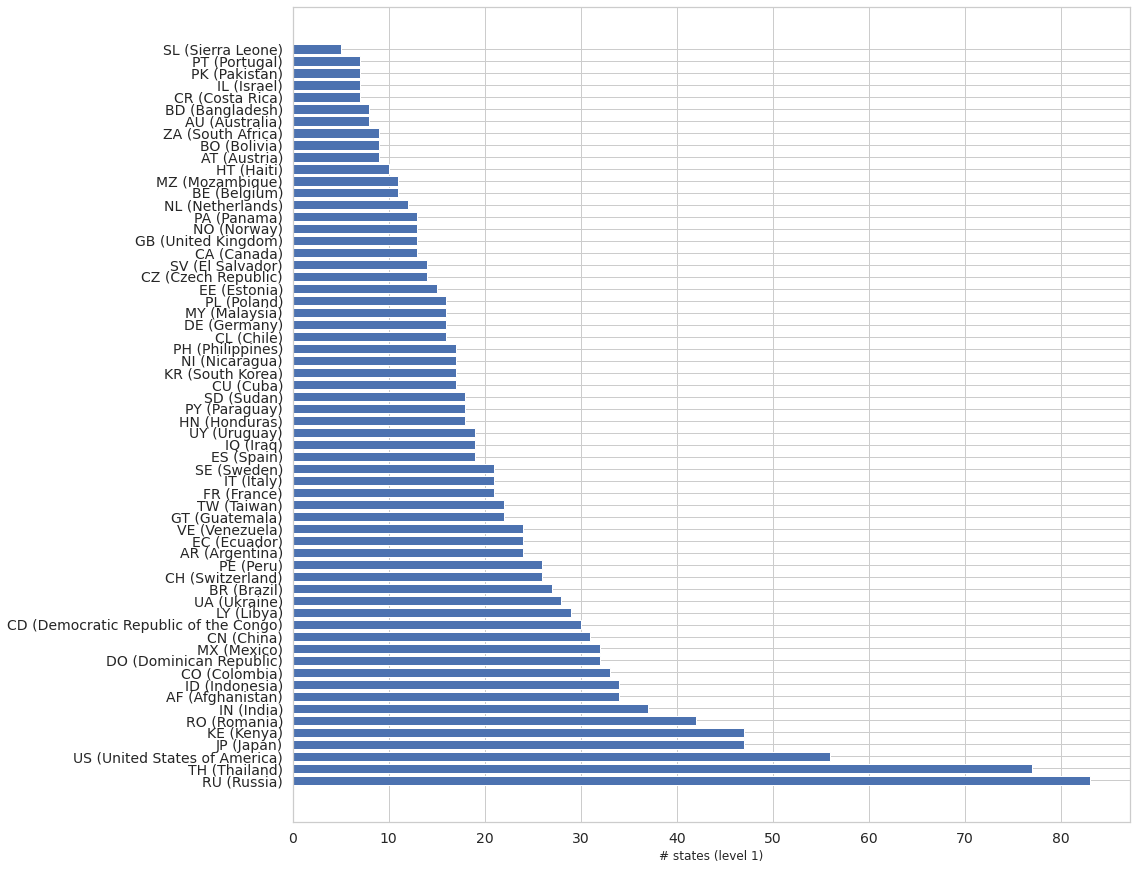

In [20]:
plt.figure(figsize=(15,15))
names = list(nstates_per_country_nonzero.keys())
counts = list(nstates_per_country_nonzero.values())
plt.barh(names, counts)
plt.xlabel('# states (level 1)')


## Level 2 (county)


In [21]:
def compute_counties():
  keys = df_index['location_key']
  counties_per_state = {}
  counties_per_country = {}

  def parse_key(key):
    parts = key.split('_')
    level = len(parts)-1
    if level==2:
      country = parts[0]
      state = parts[1]
      county = parts[2]
      state_key = f'{country}_{state}'
      try:
        counties_per_state[state_key].add(key)
      except:
        counties_per_state[state_key]  = {key}
      try:
        counties_per_country[country].add(key)
      except:
        counties_per_country[country]  = {key}

  for k in keys:
    parse_key(k)

  return counties_per_state, counties_per_country

counties_per_state, counties_per_country  = compute_counties()


In [22]:

print(len(counties_per_state['US_CA']))
print(counties_per_state['US_CA'])

print(len(counties_per_state['CA_BC']))
print(counties_per_state['CA_BC'])

print([key_name(c) for c in counties_per_state['CA_BC']])

print(len(counties_per_country['CA']))

59
{'US_CA_06059', 'US_CA_06007', 'US_CA_06081', 'US_CA_06027', 'US_CA_06071', 'US_CA_06039', 'US_CA_06067', 'US_CA_06097', 'US_CA_06015', 'US_CA_06029', 'US_CA_06103', 'US_CA_06099', 'US_CA_06101', 'US_CA_06033', 'US_CA_06109', 'US_CA_06061', 'US_CA_06083', 'US_CA_06045', 'US_CA_06091', 'US_CA_06107', 'US_CA_06021', 'US_CA_06047', 'US_CA_06041', 'US_CA_06009', 'US_CA_06077', 'US_CA_06111', 'US_CA_SFO', 'US_CA_06031', 'US_CA_06049', 'US_CA_06051', 'US_CA_06017', 'US_CA_06063', 'US_CA_06065', 'US_CA_06087', 'US_CA_06023', 'US_CA_06089', 'US_CA_06085', 'US_CA_06011', 'US_CA_06115', 'US_CA_06079', 'US_CA_06095', 'US_CA_06055', 'US_CA_06005', 'US_CA_06057', 'US_CA_06037', 'US_CA_06105', 'US_CA_06013', 'US_CA_06113', 'US_CA_06019', 'US_CA_06003', 'US_CA_06043', 'US_CA_06069', 'US_CA_06075', 'US_CA_06053', 'US_CA_06025', 'US_CA_06001', 'US_CA_06073', 'US_CA_06093', 'US_CA_06035'}
5
{'CA_BC_5920', 'CA_BC_5940', 'CA_BC_5930', 'CA_BC_5950', 'CA_BC_5910'}
['CA_BC_5920 (Canada-British Columbia-Fr

In [23]:
ncounties_per_country = {} 
for i, c in enumerate(countries):
  counties = counties_per_country.get(c, [])
  ncounties_per_country[c] = len(counties)

print(ncounties_per_country)
ncounties_per_country = {k: v for k, v in sorted(ncounties_per_country.items(), key=lambda item: -item[1])} # largest first
print(ncounties_per_country)

ncounties_per_country_nonzero = {key_name(k): v for k, v in ncounties_per_country.items() if v>0}
print(len(ncounties_per_country_nonzero)) # 23 countries have county-level info
print(ncounties_per_country_nonzero)

{'AD': 0, 'AE': 0, 'AF': 0, 'AG': 0, 'AI': 0, 'AL': 0, 'AM': 0, 'AN': 0, 'AO': 0, 'AQ': 0, 'AR': 520, 'AS': 0, 'AT': 94, 'AU': 0, 'AW': 0, 'AZ': 0, 'BA': 0, 'BB': 0, 'BD': 64, 'BE': 0, 'BF': 0, 'BG': 0, 'BH': 0, 'BI': 0, 'BJ': 0, 'BM': 0, 'BN': 0, 'BO': 0, 'BQ': 0, 'BR': 5588, 'BS': 0, 'BT': 0, 'BV': 0, 'BW': 0, 'BY': 0, 'BZ': 0, 'CA': 92, 'CC': 0, 'CD': 0, 'CF': 0, 'CG': 0, 'CH': 0, 'CI': 0, 'CK': 0, 'CL': 346, 'CM': 0, 'CN': 0, 'CO': 1122, 'CR': 0, 'CU': 0, 'CV': 0, 'CW': 0, 'CX': 0, 'CY': 0, 'CZ': 77, 'DE': 412, 'DJ': 0, 'DK': 0, 'DM': 0, 'DO': 0, 'DZ': 0, 'EC': 0, 'EE': 0, 'EG': 0, 'EH': 0, 'ER': 0, 'ES': 1378, 'ET': 0, 'FI': 0, 'FJ': 0, 'FK': 0, 'FM': 0, 'FO': 0, 'FR': 96, 'GA': 0, 'GB': 183, 'GD': 0, 'GE': 0, 'GF': 0, 'GG': 0, 'GH': 0, 'GI': 0, 'GL': 0, 'GM': 0, 'GN': 0, 'GQ': 0, 'GR': 0, 'GS': 0, 'GT': 0, 'GU': 0, 'GW': 0, 'GY': 0, 'GZ': 0, 'HK': 0, 'HM': 0, 'HN': 0, 'HR': 0, 'HT': 0, 'HU': 0, 'ID': 0, 'IE': 0, 'IL': 1483, 'IM': 0, 'IN': 735, 'IO': 0, 'IQ': 0, 'IR': 0, 'IS': 0, 

Text(0.5, 0, '# counties (level 2)')

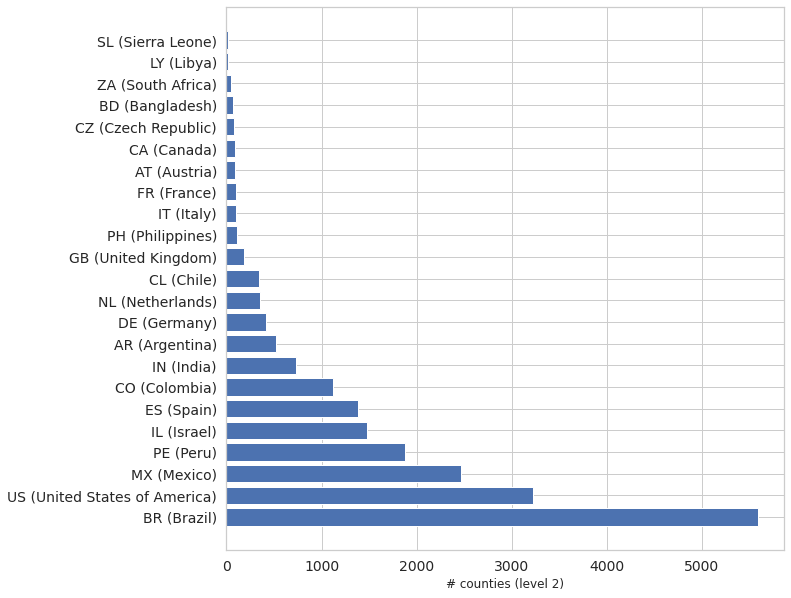

In [24]:
plt.figure(figsize=(10,10))
names = list(ncounties_per_country_nonzero.keys())
counts = list(ncounties_per_country_nonzero.values())
plt.barh(names, counts)
plt.xlabel('# counties (level 2)')

In [25]:
print(ncounties_per_country['CA'])
print(counties_per_state['CA_BC'])
for key in counties_per_state['CA_BC']:
  print(key_name(key))


92
{'CA_BC_5920', 'CA_BC_5940', 'CA_BC_5930', 'CA_BC_5950', 'CA_BC_5910'}
CA_BC_5920 (Canada-British Columbia-Fraser)
CA_BC_5940 (Canada-British Columbia-Vancouver Island)
CA_BC_5930 (Canada-British Columbia-Vancouver Coastal)
CA_BC_5950 (Canada-British Columbia-Northern)
CA_BC_5910 (Canada-British Columbia-Interior)


## Level 3 (locality)

In [26]:
# locality level, not hierarchically nested.
print(len(geo_keys_level[3]))
print(geo_keys_level[3])

32
['BR_AL_MCZ' 'BR_AM_MAO' 'BR_BA_SSA' 'BR_CE_FOR' 'BR_DF_BSB' 'BR_GO_GYN'
 'BR_MA_SLZ' 'BR_MG_CNF' 'BR_PA_BEL' 'BR_PE_REC' 'BR_PR_CWB' 'BR_RJ_GIG'
 'BR_RJ_QSD' 'BR_RS_POA' 'BR_SP_GRU' 'BR_SP_SAO' 'BR_SP_VCP' 'ES_CN_ACE'
 'ES_CN_FUE' 'ES_CN_GMZ' 'ES_CN_LPA' 'ES_CN_SPC' 'ES_CN_TFN' 'ES_CN_VDE'
 'ES_CT_BCN' 'ES_MD_MAD' 'GB_ENG_LON' 'PH_00_MNL' 'UA_KBP' 'US_CA_SFO'
 'US_GA_ATL' 'US_NY_NYC']


# Epidemiology

In [27]:
cols_idx = ['aggregation_level', 'population']
cols_epi = table_cols['epidemiology']
df_epi_all = read_data(cols_idx + cols_epi) # takes several minutes

In [28]:
print(df_epi_all.shape)
df_epi_all.sample(n=10, random_state=42) 

(8098666, 12)


,location_key,date,aggregation_level,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,cumulative_tested,population,new_tested,new_recovered,cumulative_recovered
4904018,MX_CHH_08059,2020-01-24,2,NaN,NaN,NaN,NaN,NaN,4705.0,NaN,NaN,NaN
378074,BR_AM_130210,2020-11-08,2,0.0,0.0,500.0,1.0,NaN,7326.0,NaN,NaN,NaN
3805657,GB_ENG_E06000016,2020-01-29,2,NaN,NaN,NaN,NaN,NaN,357394.0,NaN,NaN,NaN
7839190,US_TX_48087,2020-01-08,2,NaN,NaN,NaN,NaN,NaN,2964.0,NaN,NaN,NaN
6637203,PE_TUM_0201,2020-10-17,2,1.0,0.0,294.0,20.0,NaN,12371.0,NaN,NaN,NaN
1672144,BR_RJ_330470,2020-10-13,2,0.0,0.0,1191.0,21.0,NaN,40589.0,NaN,NaN,NaN
807145,BR_MA_211153,2020-03-06,2,NaN,NaN,NaN,NaN,NaN,12028.0,NaN,NaN,NaN
2081593,BR_SE_280610,2020-09-18,2,0.0,0.0,311.0,5.0,NaN,9221.0,NaN,NaN,NaN
1710052,BR_RN_240720,2020-05-10,2,0.0,0.0,1.0,0.0,NaN,28954.0,NaN,NaN,NaN
4162351,IL_M_0804,2020-08-26,2,NaN,NaN,NaN,NaN,NaN,1377.0,NaN,NaN,NaN


<a name="death-rates-per-country-time-series"></a>
## Death rates per country (time series)

In [29]:
# Exract country-level data
df_epi = df_epi_all[df_epi_all.aggregation_level == 0]
print(df_epi.shape)
df_epi.sample(n=10, random_state=42)

(90402, 12)


,location_key,date,aggregation_level,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,cumulative_tested,population,new_tested,new_recovered,cumulative_recovered
8054187,UY,2020-06-11,0,0.0,0.0,847.0,23.0,51313.0,3461734.0,840.0,NaN,NaN
6797904,SZ,2020-11-13,0,17.0,1.0,6093.0,119.0,NaN,1148130.0,NaN,NaN,NaN
3871953,GE,2020-03-19,0,10.0,0.0,48.0,0.0,NaN,3720382.0,NaN,NaN,NaN
4867117,MS,2020-03-29,0,0.0,0.0,5.0,0.0,NaN,5215.0,NaN,NaN,NaN
6789807,SN,2020-09-29,0,63.0,2.0,14982.0,311.0,185355.0,16296364.0,1266.0,NaN,NaN
6791500,SV,2020-05-15,0,55.0,2.0,1265.0,25.0,55694.0,6453553.0,2282.0,NaN,NaN
2377466,BY,2020-02-10,0,0.0,0.0,0.0,0.0,NaN,9466856.0,NaN,NaN,NaN
6647042,PH,2020-09-04,0,3875.0,57.0,257803.0,5456.0,2628970.0,108116615.0,38935.0,1060.0,59657.0
15757,AQ,2020-01-20,0,NaN,NaN,NaN,NaN,NaN,4400.0,NaN,NaN,NaN
8072487,VN,2020-06-11,0,0.0,0.0,332.0,0.0,NaN,96462106.0,NaN,NaN,NaN


In [30]:
df = df_epi[df_epi.location_key == 'US']
dates = df.date
print(f'US epi data from {min(dates)} to {max(dates)}')

US epi data from 2020-01-01 to 2020-12-31


In [31]:
def plot_death_rate_helper(df, ax, country, cumulative):
  df = df.dropna(subset=['new_deceased', 'cumulative_deceased'])
  new_deceased_normalized = df['new_deceased'] / df['population'] * 100_000
  cum_deceased_normalized = df['cumulative_deceased'] / df['population'] * 100_000
  current_cum_deceased = list(df['cumulative_deceased'].values)[-1] # most recent
  df2 = pd.DataFrame({'date': df['date'],
                      'new_deceased_per100k': new_deceased_normalized,
                      'cum_deceased_per100k': cum_deceased_normalized})
  if cumulative:
    df2.plot(ax=ax, x='date', y='cum_deceased_per100k',
          title = f'cum deceased per 100k',
          label = f'{key_name(country)}, current {current_cum_deceased:,}')
  else:
    df2.plot(ax=ax, x='date', y='new_deceased_per100k',
            title = f'new deceased per 100k',
            label = key_name(country))

    
def plot_death_rate(country_list, cumulative=False):
  fig, ax = plt.subplots(1,1, figsize=(20,10))
  for country in country_list:
    df = df_epi[df_epi.location_key == country]
    plot_death_rate_helper(df, ax, country, cumulative)
  
 
  

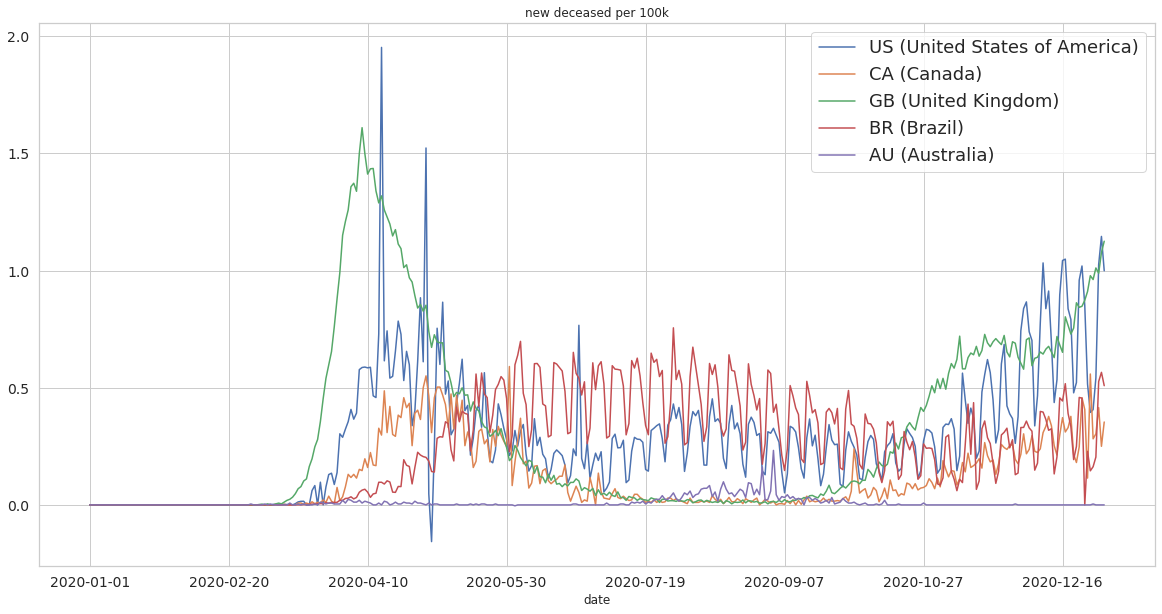

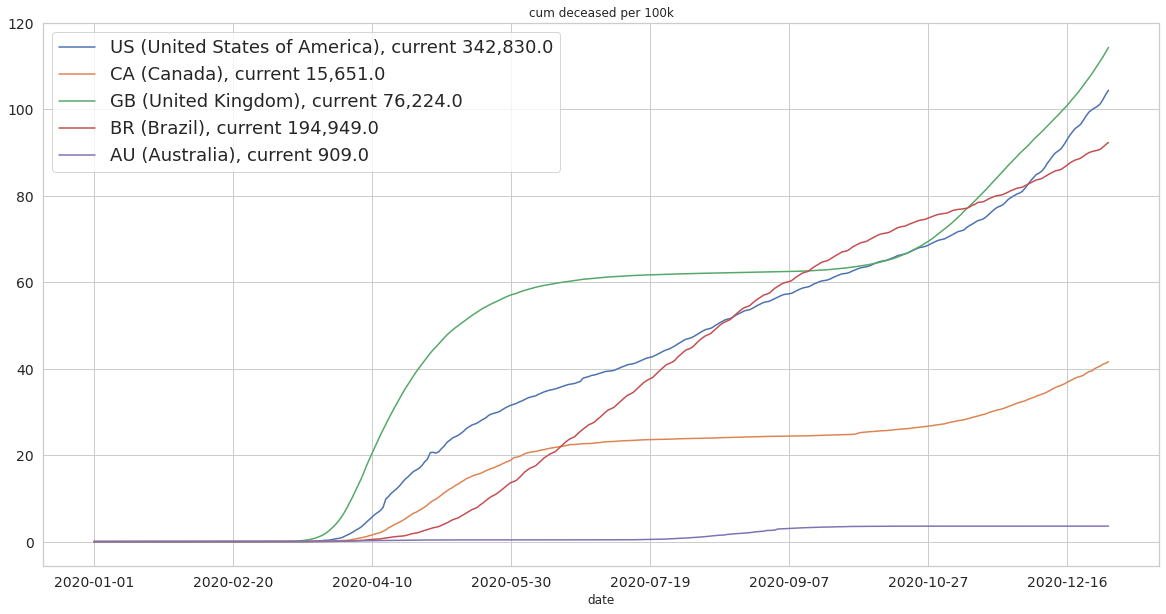

In [32]:
plot_death_rate(['US', 'CA', 'GB', 'BR', 'AU'])
plot_death_rate(['US', 'CA', 'GB', 'BR', 'AU'], cumulative=True)

## Death rates per country (ranking) 

We compute the total number of deaths for each country, divided by population size, and call this the 'covid severity index'.

In [33]:
def get_most_recent_value(df, col):
  dates = df['date']
  if len(dates)==0:
    return None
  last_date = max(dates)
  df_tmp = df[df.date == last_date]
  val = df_tmp[col].values[0]
  return val

def compute_latest_death_rate(country):
  df = df_epi[df_epi['location_key'] == country]
  df = df[['cumulative_deceased', 'date', 'population']]
  df = df.dropna(subset=['cumulative_deceased'])
  latest_cum_death = get_most_recent_value(df, 'cumulative_deceased')
  if latest_cum_death is None:
     print(f'{key_name(country)} has no death data')
     return 0
  pop = df['population'].values[0]
  return latest_cum_death / pop * 100_000

countries = set(df_epi.location_key.values)
death_rates = {}
for country in countries:
  d = compute_latest_death_rate(country)
  if d > 0: 
    death_rates[country] = d

print(death_rates)


UM (United States Minor Outlying Islands) has no death data
AQ (Antarctica) has no death data
IO (British Indian Ocean Territory) has no death data
NF (Norfolk Island) has no death data
SJ (Svalbard and Jan Mayen) has no death data
BQ (Caribbean Netherlands) has no death data
GS (South Georgia and the South Sandwich Islands) has no death data
TF (French Southern Territories) has no death data
CX (Christmas Island) has no death data
CC (Cocos Islands) has no death data
GZ (Gaza Strip) has no death data
BV (Bouvet Island) has no death data
HM (Heard Island and McDonald Islands) has no death data
AN (Netherlands Antilles) has no death data
EH (Western Sahara) has no death data
{'ZW': 2.4785824529472187, 'MM': 4.9902470921680315, 'EE': 18.191150495916425, 'LB': 21.38362559809607, 'MQ': 11.540711874050576, 'GU': 72.92550838643346, 'FI': 10.166876316959346, 'IT': 122.8620904471349, 'XK': 70.36576389604348, 'AF': 5.812034849917803, 'BG': 108.6279662156168, 'TT': 9.104118861081899, 'SR': 20.98

In [34]:
df_death_rate = pd.DataFrame({'location_key': death_rates.keys(),
                   'country': [key_name(c) for c in death_rates.keys()], 
                    'deaths-per-100k': death_rates.values()})
#df_death_rate = df_death_rate.set_index('location_key')
df_death_rate = df_death_rate.sort_values('deaths-per-100k', ascending=False)
display(df_death_rate)

,location_key,country,deaths-per-100k
51,SM,SM (San Marino),174.246899
92,BE,BE (Belgium),171.480664
76,SI,SI (Slovenia),131.433009
66,PE,PE (Peru),128.392039
162,BA,BA (Bosnia and Herzegovina),123.780673
...,...,...,...
36,ER,ER (Eritrea),0.085788
145,VN,VN (Vietnam),0.036284
143,TZ,TZ (Tanzania),0.036203
138,TW,TW (Taiwan),0.029669


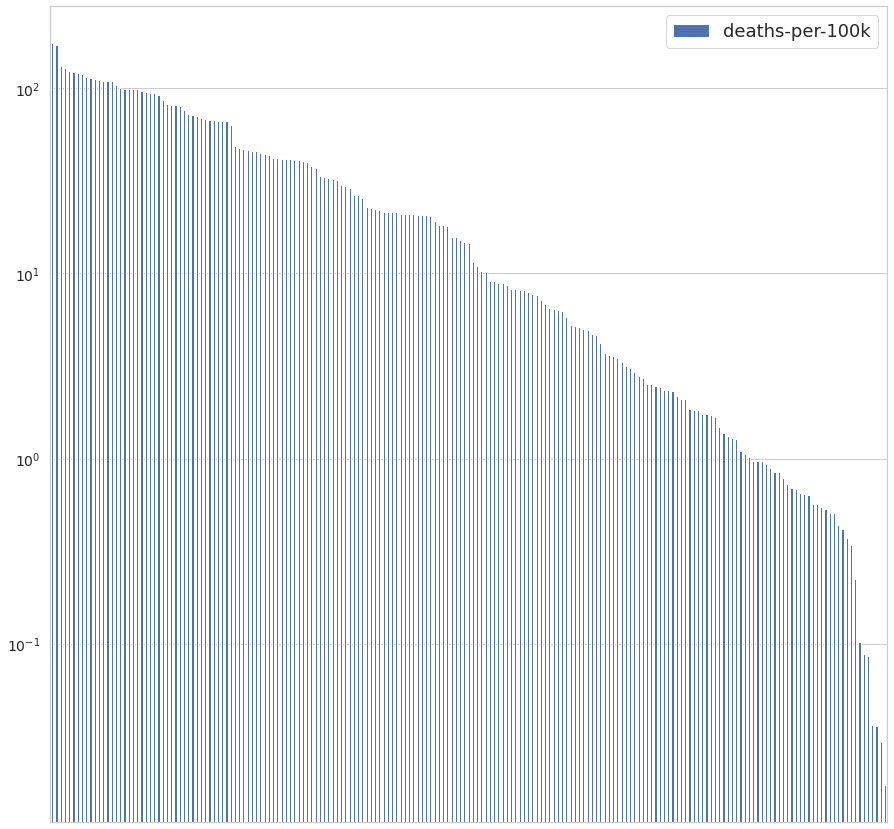

In [35]:
df_death_rate.plot.bar(figsize=(15,15), xticks=[], logy=True)

# Government interventions 

In [38]:
cols_gov = table_cols['oxford-government-response']
df_gov_all = read_data(cols_gov) # takes several minutes

In [39]:

print(df_gov_all.shape)
display(df_gov_all.sample(n=20, random_state=42))


(8098666, 23)


,location_key,date,aggregation_level,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,income_support,debt_relief,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
4904018,MX_CHH_08059,2020-01-24,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378074,BR_AM_130210,2020-11-08,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3805657,GB_ENG_E06000016,2020-01-29,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7839190,US_TX_48087,2020-01-08,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6637203,PE_TUM_0201,2020-10-17,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1672144,BR_RJ_330470,2020-10-13,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
807145,BR_MA_211153,2020-03-06,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2081593,BR_SE_280610,2020-09-18,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1710052,BR_RN_240720,2020-05-10,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4162351,IL_M_0804,2020-08-26,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Exract country-level data
df_gov = df_gov_all[df_gov_all.aggregation_level == 0]
print(df_gov.shape)
df_gov.sample(n=10, random_state=42)

In [ ]:
df_gov = df_gov.dropna(subset=['stringency_index'])
countries = set(df_gov['location_key'].values)
print(len(countries)) # country level data for 184 countries
print(countries)

In [ ]:
df = df_gov[df_gov.location_key == 'US']
df.head()

In [ ]:

def plot_gov_time_series(country_list):
  fig, ax = plt.subplots(1,1,figsize=(20,10))
  for country in country_list:
    df = df_gov[df_gov.location_key == country]
    df.plot(ax=ax, x='date', y='stringency_index', label=country, title='Govt. stringency index')

plot_gov_time_series(['US', 'CA', 'GB', 'BR', 'AU'])

# Mobility

In [ ]:
cols_idx = ['location_key', 'date', 'aggregation_level']
cols_mob = table_cols['mobility']
df_mob_all = get_agg_data(cols_idx + cols_mob) # takes several minutes

In [ ]:
print(df_mob_all.shape)
df_mob_all.sample(n=10, random_state=42)

In [ ]:

# Exract country-level data
df_mob = df_mob_all[df_mob_all.aggregation_level == 0]
print(df_mob.shape)
df_mob.sample(n=10, random_state=42)

In [ ]:
df_mob = df_mob.dropna(subset=['mobility_parks']) # drop rows where mobbility is missing
print(df_mob.shape)
countries = set(df_mob['location_key'].values)
print(len(countries)) # country level data for 134 countries
print(countries)

In [ ]:
df = df_mob[df_mob['location_key'] == 'GB']
df.head()


In [ ]:
df.columns

In [ ]:
# comptue average mobility index for each country.
# We standardize each column  since they have very different magnitudes

from sklearn import preprocessing

def standardize_col(df):
  x = df.to_numpy()
  min_max_scaler = preprocessing.StandardScaler()
  x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
  return x_scaled

def compute_avg_mobility(df):
  mob_names = table_cols['mobility']
  mob = standardize_col(df[mob_names[0]])
  N = len(mob_names)
  for i in range(1, N):
    mob += mob + standardize_col(df[mob_names[i]])
  mob = mob / N 
  df = df.assign(mobility_index=mob)
  return df


In [ ]:
df2 = compute_avg_mobility(df)
df2.columns

In [ ]:
xs = np.arange(0,10); ndx=np.where(xs > 5); print(ndx)

In [ ]:
import matplotlib.dates as mdates

def plot_mob_time_series(country_list, col='mobility_index', annotate_outliers=False):
  fig, ax = plt.subplots(1,1,figsize=(20,10))
  for country in country_list:
    df = df_mob[df_mob['location_key'] == country]
    df = compute_avg_mobility(df) 
    df.plot(ax=ax, x='date', y=col, label=country, title=col)
    date = df['date'].to_numpy()
    vals = df[col].to_numpy()
    #ax.plot(date, vals)
    if annotate_outliers:
      # https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html
      # https://goodboychan.github.io/chans_jupyter/python/datacamp/visualization/2020/06/26/02-Plotting-time-series.html
      mu = np.mean(vals)
      sd = np.std(vals)
      ndx = np.where(vals >= mu + 2*sd)[0]
      for i in []: #ndx:
        print(date[i])
        #ax.text(date[i], vals[i], 'o')
        #ax.text(mdates.datestr2num('2020-04-01'), 20, 'x')
        #ax.text(pd.Timestamp('2020-04-01'), 20, 'x')
        ax.annotate('>1 degree', (date[i], vals[i]))



In [ ]:
plot_mob_time_series(['US'])

In [ ]:
plot_mob_time_series(['US', 'CA', 'GB', 'BR', 'AU'])


In [ ]:
plot_mob_time_series(['CA'])

In [ ]:
for mob in table_cols['mobility']:
  plot_mob_time_series(['US', 'CA', 'GB', 'BR', 'AU'], mob)

In [ ]:
plot_mob_time_series(['US', 'CA', 'GB', 'BR', 'AU'], 'mobility_parks')

# Static features

We combine all the static tables, except worldbank.


In [ ]:
df_static_all = df_index

df_demo = pd.read_csv(f'{ROOT}/demographics.csv', **READ_OPTS) 
df_static_all = df_static_all.merge(df_demo, how='left')

df_econ = pd.read_csv(f'{ROOT}/economy.csv', **READ_OPTS) 
df_static_all = df_static_all.merge(df_econ, how='left')

df_geo = pd.read_csv(f'{ROOT}/geography.csv', **READ_OPTS)
df_static_all = df_static_all.merge(df_geo, how='left')

df_health = pd.read_csv(f'{ROOT}/health.csv', **READ_OPTS)
df_static_all = df_static_all.merge(df_health, how='left')

print(df_static_all.shape)
df_static_all.sample(n=5, random_state=42)

## What correlates with death rate per country?

In [ ]:
# get country level static data
df_static = df_static[df_static_all.aggregation_level == 0]
print(df_static.shape)
df_static.sample(n=5, random_state=42)


In [ ]:
def make_scatter_plot_for_countries(col1, col2, df):
  df = df[['location_key', col1, col2]]
  df = df.dropna(subset=[col1]) # drop rows where target value is missing
  df = df.dropna(subset=[col2]) # drop rows where target value is missing
  keys = df.location_key.values
  names = [key_name(c) for c in keys]
  plt.figure(figsize=(10,10))
  xs = df[col1].values;
  ys = df[col2].values
  plt.scatter(xs, ys)
  plt.xlabel(col1)
  plt.ylabel(col2)
  N = len(names)
  plt.title(f'N={N} countries')
  for i, txt in enumerate(names):
    plt.annotate(txt, (xs[i], ys[i])) 


In [ ]:
df = df_static[['location_key', 'gdp_per_capita_usd', 'life_expectancy']]
df = df.merge(df_death_rate, how='left')
df.sample(n=5, random_state=0)

In [ ]:
make_scatter_plot_for_countries('gdp_per_capita_usd', 'deaths-per-100k', df)

In [ ]:
make_scatter_plot_for_countries('life_expectancy', 'deaths-per-100k', df)

## Which static features are correlated?

In [ ]:

make_scatter_plot_for_countries('gdp_per_capita_usd', 'life_expectancy', df_static)

In [ ]:
make_scatter_plot_for_countries('human_development_index', 'life_expectancy', df_static)

In [ ]:
make_scatter_plot_for_countries('human_development_index', 'human_capital_index', df_static)